Copyright (c) 2020, salesforce.com, inc.  
All rights reserved.  
SPDX-License-Identifier: BSD-3-Clause  
For full license text, see the LICENSE file in the repo root or https://opensource.org/licenses/BSD-3-Clause

### Colab

Try this notebook on [Colab](http://colab.research.google.com/github/salesforce/ai-economist/blob/master/tutorials/optimal_taxation_theory_and_simulation.ipynb).

This tutorial demonstrates how the economic simulation can be used to study the problem of **optimal taxation**.

We begin with a brief introduction of optimal taxation and then show how we implement it in simulation.  

For further reading, check out the AI Economist [paper](https://arxiv.org/abs/2004.13332) and [blog post](https://blog.einstein.ai/the-ai-economist/).

# Optimal Taxation: Basics

Broadly speaking, optimal taxation is concerned with how to best use taxes to achieve some socially desirable economic outcome, such as a society that is both prosperous and equitable.

Much of the theory around this problem builds on the models developed by James Mirrlees and colleagues in the 1970s (see [Mirrlees, 1971](https://www.jstor.org/stable/2296779?seq=1)). There are several key concepts throughout this line of work which we will introduce below:

* **A population of income earners**: workers in the economy, who earn income by performing labor.
* **Skill** (or wage): the amount of income a worker is able to receive per unit labor.
* **Utility**: the happiness each worker experiences and tries to maximize.
* **A social planner**, which sets income tax rates and creates income redistribution.
* **Social welfare**: the objective the planner tries to maximize.

## Individual Workers: Skill, Labor, Income, and Utility

- Each worker wants to maximize his/her own happiness (utility).
- Each worker gains utility from having money and loses utility from doing work.
- We also assume that there is **diminishing marginal utility** from money and/or **increasing marginal cost** from doing work.
- This means that there is a _sweet spot_ in the amount of work done/income earned where utility is maximized.

Let's explore this with some code. We define methods that implement income and utility, using skill as an input:

In [1]:
def income_earned(labor, skill):
    """Income is amount of work (labor) times skill."""
    return labor * skill

def utility(labor, skill):
    """Utility is convex increasing in income and linearly decreasing in amount of work (labor)."""

    def isoelastic_utility(z, eta=0.35):
        """Utility gained from income z: https://en.wikipedia.org/wiki/Isoelastic_utility"""
        return (z**(1-eta) - 1) / (1 - eta)
    
    income = income_earned(labor, skill)
    utility_from_income = isoelastic_utility(income)
    disutility_from_labor = labor
    
    # Total utility is utility from income minus disutility incurred from working
    return utility_from_income - disutility_from_labor

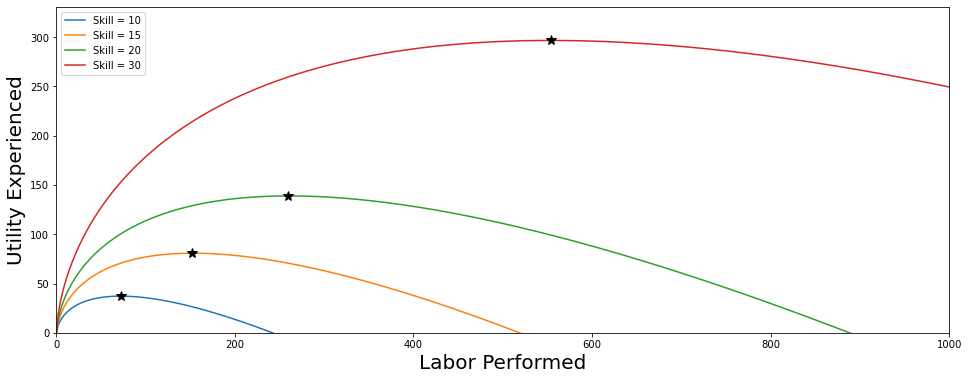

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def plot_utility_curve(skill, ax):
    """Plot the curve relating labor performed to total utility."""
    labor_array = np.linspace(0, 1000, 501)
    utility_array = utility(labor_array, skill)
    ax.plot(labor_array, utility_array, label="Skill = {}".format(skill))
    ax.plot(labor_array[np.argmax(utility_array)], np.max(utility_array), 'k*', markersize=10)
    
fig, ax = plt.subplots(1, 1, figsize=(16, 6))

for skill in [10, 15, 20, 30]:
    plot_utility_curve(skill, ax)
    
ax.set_xlabel("Labor Performed", fontsize=20)
ax.set_ylabel("Utility Experienced", fontsize=20)
ax.set_xlim(left=0, right=1000)
ax.set_ylim(bottom=0)
ax.legend();

Notice that in this visual demonstration, we've brought in the concept of **skill**, which describes how much income a worker makes per unit of labor. Skill is very important for a couple reasons:
* First, the amount of income a worker gets affects how much he/she will choose to work (and, choose to earn) to maximize utility.  
More skill -> more labor -> more total income --> more utility.
* Second, **skill is not equal among workers**. Moreover, the market may value the labor of one worker much more than that of another, leading to **income inequality** and large differences in how much utility each agent is able to experience.

## Social Planner: taxes and social welfare
How can we create a more equitable economy?
- A naive approach may be to move money from rich workers to poor workers through **taxation and redistribution**.
- The challenge there is that workers choose how much to work based on how much they earn from working, and taxes (from the worker's perspective) cause that to go down.  
- **In other words, higher income tax -> less overall income to tax.**

Just like workers want to maximize their own utility, the social planner has its own objective called **social welfare**. It is up to society to settle on a good definition of social welfare. 

The challenge of optimal taxation arises when social welfare emphasizes both equality (similar incomes/utilities) and productivity (total income/utility), *because there is an inherent trade-off between the two*.

# Theory to Simulation

Economic theory has studied this problem in various modeling settings, but it remains hard to mathematically derive the optimal tax policy. 

- Simple economies yield [mathematically tractable tax formulas](https://eml.berkeley.edu/~saez/saez-stantchevaJpubE18optKtax.pdf), but fail to capture the rich dynamics of a more realistic economy.
- Complex economies can describe economic processes and actors more accurately (e.g., [the New Dynamic Public Finance](https://econpapers.repec.org/bookchap/puppbooks/9222.htm)), but lead to tax formulas that are hard to explicitly calculate.

Simulation offers a lens to understand these dynamics and enables us to use reinforcement learning to *learn* optimal tax policies. However, a good simulation is grounded in the same intuitions underlying simpler, theoretical models.

Below, we unpack our approach for studying the optimal taxation problem in simulation, and highlight how we can validate emergent economic behavior.

# Simulating the optimal taxation problem

Let's start with the full environment and then zoom in as needed to see how it is grounded in the key concepts of optimal taxation.  

Before moving forward, you should be familiar with the basics for how to build simulation environments in our framework. Check out:

- [Basics tutorial](https://github.com/salesforce/ai-economist/blob/master/tutorials/economic_simulation_basic.ipynb): this tutorial shows how to interact with the simulation.
- [Advanced tutorial](https://github.com/salesforce/ai-economist/blob/master/tutorials/economic_simulation_advanced.ipynb): this tutorial shows how the simulation is composed out of flexible building blocks, such as Resources, Agents, and Components.
- The code and documentation for the [core classes](https://github.com/salesforce/ai-economist/blob/master/ai_economist/foundation/base).

## Dependencies:
You can install the ai-economist package using 
- the pip package manager OR
- by cloning the ai-economist package and installing the requirements (we shall use this when running on Colab):

In [3]:
import os, signal, sys, time
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # !git clone https://github.com/salesforce/ai-economist.git

    # %cd ai-economist
    # !pip install -e .
    
    # Restart the Python runtime to automatically use the installed packages
    print("\n\nRestarting the Python runtime! Please (re-)run the cells below.")
    time.sleep(1)
    os.kill(os.getpid(), signal.SIGKILL)
else:
    # !pip install ai-economist
    pass

In [4]:
# Import foundation from source
from ai_economist import foundation

Inside covid19_components.py: 0 GPUs are available.
No GPUs found! Running the simulation on a CPU.
Inside covid19_env.py: 0 GPUs are available.
No GPUs found! Running the simulation on a CPU.


In [5]:
# Define the configuration of the environment that will be built

env_config = {
    # ===== SCENARIO CLASS =====
    # Which Scenario class to use: the class's name in the Scenario Registry (foundation.scenarios).
    # The environment object will be an instance of the Scenario class.
    'scenario_name': 'layout_from_file/simple_wood_and_stone',
    
    # ===== COMPONENTS =====
    # Which components to use (specified as list of ("component_name", {component_kwargs}) tuples).
    #     "component_name" refers to the Component class's name in the Component Registry (foundation.components)
    #     {component_kwargs} is a dictionary of kwargs passed to the Component class
    # The order in which components reset, step, and generate obs follows their listed order below.
    'components': [
        # (1) Building houses
        ('Build', dict(skill_dist="pareto", payment_max_skill_multiplier=3)),
        # (2) Trading collectible resources
        ('ContinuousDoubleAuction', dict(max_num_orders=5)),
        # (3) Movement and resource collection
        ('Gather', dict()),
        # (4) Income tax & lump-sum redistribution
        ('PeriodicBracketTax', dict(bracket_spacing="us-federal", period=100))
    ],
    
    # ===== SCENARIO CLASS ARGUMENTS =====
    # (optional) kwargs that are added by the Scenario class (i.e. not defined in BaseEnvironment)
    'env_layout_file': "quadrant_25x25_20each_30clump.txt",
    'fixed_four_skill_and_loc': True,
    
    # ===== STANDARD ARGUMENTS ======
    # kwargs that are used by every Scenario class (i.e. defined in BaseEnvironment)
    'n_agents': 4,          # Number of non-planner agents (must be >1)
    'world_size': [25, 25], # [Height, Width] of the env world
    'episode_length': 1000, # Number of timesteps per episode
    
    # In multi-action-mode, the policy selects an action for each action subspace (defined in component code).
    # Otherwise, the policy selects only 1 action.
    'multi_action_mode_agents': False,
    'multi_action_mode_planner': True,
    
    # When flattening observations, concatenate scalar & vector observations before output.
    # Otherwise, return observations with minimal processing.
    'flatten_observations': False,
    # When Flattening masks, concatenate each action subspace mask into a single array.
    # Note: flatten_masks = True is required for masking action logits in the code below.
    'flatten_masks': True,
}

The following line of code creates an instance of a **Scenario** object. More specifically, ```make_env_instance``` finds the Scenario class associated with name ```'layout_from_file/simple_wood_and_stone'``` and returns an instance of it using the rest of ```env_config``` as keyword arguments during construction.

In [6]:
env = foundation.make_env_instance(**env_config)
obs = env.reset()

## Individual workers ("agents")

```env_config``` specifies that our environment should include 4 individual worker agents (```env_config['n_agents']```).

Each worker agent is represented as a separate Python object:

In [7]:
env.world.agents

Each agent object stores its own state information, like location, endowments, etc.:

In [8]:
env.world.agents[0].state

{'loc': [0, 24],
 'inventory': {'Coin': 0.0, 'Stone': 0, 'Wood': 0},
 'escrow': {'Coin': 0, 'Stone': 0, 'Wood': 0},
 'endogenous': {'Labor': 0},
 'build_payment': 11.331640623590097,
 'build_skill': 0.05307532923146163,
 'bonus_gather_prob': 0.0}

Worker agents are keyed by numerical indices. These can be used, for example, to look them up and to associate particular agent objects with specific observations:

In [9]:
agent0 = env.get_agent(agent_idx=0)
agent0.idx

0

In [10]:
print(obs.keys())
print(obs['0'].keys())

dict_keys(['0', '1', '2', '3', 'p'])
dict_keys(['world-map', 'world-idx_map', 'world-loc-row', 'world-loc-col', 'world-inventory-Coin', 'world-inventory-Stone', 'world-inventory-Wood', 'time', 'Build-build_payment', 'Build-build_skill', 'ContinuousDoubleAuction-market_rate-Stone', 'ContinuousDoubleAuction-price_history-Stone', 'ContinuousDoubleAuction-available_asks-Stone', 'ContinuousDoubleAuction-available_bids-Stone', 'ContinuousDoubleAuction-my_asks-Stone', 'ContinuousDoubleAuction-my_bids-Stone', 'ContinuousDoubleAuction-market_rate-Wood', 'ContinuousDoubleAuction-price_history-Wood', 'ContinuousDoubleAuction-available_asks-Wood', 'ContinuousDoubleAuction-available_bids-Wood', 'ContinuousDoubleAuction-my_asks-Wood', 'ContinuousDoubleAuction-my_bids-Wood', 'Gather-bonus_gather_prob', 'PeriodicBracketTax-is_tax_day', 'PeriodicBracketTax-is_first_day', 'PeriodicBracketTax-tax_phase', 'PeriodicBracketTax-last_incomes', 'PeriodicBracketTax-curr_rates', 'PeriodicBracketTax-marginal_rate

## Utility

Basic economic intuition (see above) is that each agent attempts to maximize its own utility. In a reinforcement learning context, this means that each agent wants to maximize the sum of marginal utilities experienced at each future timestep. **In other words, we want to use marginal utility as the agent's reward.**

Each Scenario class must implement the reward function in method ```compute_rewards```. The Scenario class that ```env``` belongs to makes use of the following function:

```python
def isoelastic_coin_minus_labor(
    coin_endowment, total_labor, isoelastic_eta, labor_coefficient
):
    """Agent utility, concave increasing in coin and linearly decreasing in labor.

    Args:
        coin_endowment (float, ndarray): The amount of coin owned by the agent(s).
        total_labor (float, ndarray): The amount of labor performed by the agent(s).
        isoelastic_eta (float): Constant describing the shape of the utility profile
            with respect to coin endowment. Must be between 0 and 1. 0 yields utility
            that increases linearly with coin. 1 yields utility that increases with
            log(coin). Utility from coin uses:
                https://en.wikipedia.org/wiki/Isoelastic_utility
        labor_coefficient (float): Constant describing the disutility experienced per
            unit of labor performed. Disutility from labor equals:
                labor_coefficient * total_labor

    Returns:
        Agent utility (float) or utilities (ndarray).
    """
    # https://en.wikipedia.org/wiki/Isoelastic_utility
    assert np.all(coin_endowment >= 0)
    assert 0 <= isoelastic_eta <= 1.0

    # Utility from coin endowment
    if isoelastic_eta == 1.0:  # dangerous
        util_c = np.log(np.max(1, coin_endowment))
    else:  # isoelastic_eta >= 0
        util_c = (coin_endowment ** (1 - isoelastic_eta) - 1) / (1 - isoelastic_eta)

    # disutility from labor
    util_l = total_labor * labor_coefficient

    # Net utility
    util = util_c - util_l

    return util
```

Note that this is essentially the same definition of utility we used above!

```env.compute_rewards``` uses this utility function to compute utilities from agent's coin endowments (```agent.state['inventory']['Coin'] + agent.state['escrow']['Coin']```) and accumulated labor (```agent.state['endogenous']['Labor']```) at the end of each step. It returns as reward the change in utility from the previous step.

Let's look at the code that implements this:

```python
# Excerpts from the Scenario class code:
    
    def get_current_optimization_metrics(self):
        """
        Compute optimization metrics based on the current state. Used to compute reward.

        Returns:
            curr_optimization_metric (dict): A dictionary of {agent.idx: metric}
                with an entry for each agent (including the planner) in the env.
        """
        curr_optimization_metric = {}
        # (for agents)
        for agent in self.world.agents:
            curr_optimization_metric[agent.idx] = rewards.isoelastic_coin_minus_labor(
                coin_endowment=agent.total_endowment("Coin"),
                total_labor=agent.state["endogenous"]["Labor"],
                isoelastic_eta=self.isoelastic_eta,
                labor_coefficient=self.energy_weight * self.energy_cost,
            )
            
        # ... omitting for brevity the planner's optimization metric ...
        
        return curr_optimization_metric
    
    def compute_reward(self):
        """
        Apply the reward function(s) associated with this scenario to get the rewards
        from this step.

        Returns:
            rew (dict): A dictionary of {agent.idx: agent_obs_dict}. In words,
                return a dictionary with an entry for each agent in the environment
                (including the planner). For each entry, the key specifies the index of
                the agent and the value contains the scalar reward earned this timestep.

        Rewards are computed as the marginal utility (agents) or marginal social
        welfare (planner) experienced on this timestep. Ignoring discounting,
        this means that agents' (planner's) objective is to maximize the utility
        (social welfare) associated with the terminal state of the episode.
        """

        # "curr_optimization_metric" hasn't been updated yet, so it gives us the
        # utility from the last step.
        utility_at_end_of_last_time_step = deepcopy(self.curr_optimization_metric)

        # compute current objectives and store the values
        self.curr_optimization_metric = self.get_current_optimization_metrics()

        # reward = curr - prev objectives
        rew = {
            k: float(v - utility_at_end_of_last_time_step[k])
            for k, v in self.curr_optimization_metric.items()
        }

        return rew
```

## Labor

In order to recreate the optimal tax problem, it is not enough simply to use a utility-based reward function. We have to design our simulation such that agents experience a labor cost associated with the actions that ultimately create income. That is, work needs to feel like work!

An example is found in the part of the environment that enables workers to move around and gather resources: the ```Gather``` Component class. Below, we highlight the portions of the class's code that associate a labor cost with moving and resource collection:

```python
import numpy as np
from numpy.random import rand

from ai_economist.foundation.base.base_component import BaseComponent, component_registry


@component_registry.add
class Gather(BaseComponent):
    """
    Allows mobile agents to move around the world and collect resources and prevents
    agents from moving to invalid locations.

    Can be configured to include collection skill, where agents have heterogeneous
    probabilities of collecting bonus resources without additional labor cost.

    Args:
        move_labor (float): Labor cost associated with movement. Must be >= 0.
            Default is 1.0.
        collect_labor (float): Labor cost associated with collecting resources. This
            cost is added (in addition to any movement cost) when the agent lands on
            a tile that is populated with resources (triggering collection).
            Must be >= 0. Default is 1.0.
        skill_dist (str): Distribution type for sampling skills. Default ("none")
            gives all agents identical skill equal to a bonus prob of 0. "pareto" and
            "lognormal" sample skills from the associated distributions.
    """

    name = "Gather"
    required_entities = ["Coin", "House", "Labor"]
    agent_subclasses = ["BasicMobileAgent"]

    def __init__(
        self,
        *base_component_args,
        move_labor=1.0,
        collect_labor=1.0,
        skill_dist="none",
        **base_component_kwargs
    ):
        super().__init__(*base_component_args, **base_component_kwargs)

        self.move_labor = float(move_labor)
        assert self.move_labor >= 0

        self.collect_labor = float(collect_labor)
        assert self.collect_labor >= 0


    def component_step(self):
        """
        See base_component.py for detailed description.

        Move to adjacent, unoccupied locations. Collect resources when moving to
        populated resource tiles, adding the resource to the agent's inventory and
        de-populating it from the tile.
        """
        world = self.world

        for agent in world.get_random_order_agents():

            if self.name not in agent.action:
                return
            action = agent.get_component_action(self.name)

            r, c = [int(x) for x in agent.loc]

            if action == 0:  # NO-OP!
                new_r, new_c = r, c

            elif action <= 4:
                if action == 1:  # Left
                    new_r, new_c = r, c - 1
                elif action == 2:  # Right
                    new_r, new_c = r, c + 1
                elif action == 3:  # Up
                    new_r, new_c = r - 1, c
                else:  # action == 4, # Down
                    new_r, new_c = r + 1, c

                # Attempt to move the agent (if the new coordinates aren't accessible,
                # nothing will happen)
                new_r, new_c = world.set_agent_loc(agent, new_r, new_c)

                # If the agent did move, incur the labor cost of moving
                if (new_r != r) or (new_c != c):
                    agent.state["endogenous"]["Labor"] += self.move_labor # <----- LABOR HERE...

            else:
                raise ValueError

            for resource, health in world.location_resources(new_r, new_c).items():
                if health >= 1:
                    n_gathered = 1 + (rand() < agent.state["bonus_gather_prob"])
                    agent.state["inventory"][resource] += n_gathered
                    world.consume_resource(resource, new_r, new_c)
                    # Incur the labor cost of collecting a resource
                    agent.state["endogenous"]["Labor"] += self.collect_labor # <----- ...AND HERE
```

In ```component_step```, each time an agent changes its location it adds ```self.move_labor``` to its accumulated labor, and each time it collects resources from the world it adds ```self.collect_labor``` to its accumulated labor.

Resources are valuable because agents can use them to generate income, either by using them to build houses or by selling them to other agents. 

As such, and in keeping with the intuitions of the simpler theoretical model, **agents earn income by performing labor.**

## Skill

Recall that ***skill* describes the amount of income an agent is able to receive per unit of labor it performs.** In our environment, there is no direct conversion from labor to income: doing things that cost labor don't necessarily yield income; however, earning income requires taking some actions (which cost labor).  

So, in our simulation, an agent's *skill* is better understood as the ratio of income-to-labor that it is able to achieve. We don't control this ratio directly but we can still create a population of heterogeneously skilled agents by allowing some agents to earn more than others for particular behaviors.  

The best example is found in the part of the environment that enables worker agents to build houses: the ```Build``` Component class. The code snippets below demonstrate how this is achieved.

Starting with the ```Build.__init__``` method, each of the 4 custom arguments influence agents' *skill* as defined above. The method code itself is just setting up some parameters that will come into play. 

```python
import numpy as np

from ai_economist.foundation.base.base_component import BaseComponent, component_registry


@component_registry.add
class Build(BaseComponent):
    """
    Allows mobile agents to build house landmarks in the world using stone and wood,
    earning income.

    Can be configured to include heterogeneous building skill where agents earn
    different levels of income when building.

    Args:
        payment (int): Default amount of coin agents earn from building.
            Must be >= 0. Default is 10.
        payment_max_skill_multiplier (int): Maximum skill multiplier that an agent
            can sample. Must be >= 1. Default is 1.
        skill_dist (str): Distribution type for sampling skills. Default ("none")
            gives all agents identical skill equal to a multiplier of 1. "pareto" and
            "lognormal" sample skills from the associated distributions.
        build_labor (float): Labor cost associated with building a house.
            Must be >= 0. Default is 10.
    """

    name = "Build"
    mech_type = "Build"
    required_entities = ["Wood", "Stone", "Coin", "House", "Labor"]
    agent_subclasses = ["BasicMobileAgent"]

    def __init__(
        self,
        *base_component_args,
        payment=10,
        payment_max_skill_multiplier=1,
        skill_dist="none",
        build_labor=10.0,
        **base_component_kwargs
    ):
        super().__init__(*base_component_args, **base_component_kwargs)

        self.payment = int(payment)
        assert self.payment >= 0

        self.payment_max_skill_multiplier = int(payment_max_skill_multiplier)
        assert self.payment_max_skill_multiplier >= 1

        self.resource_cost = {"Wood": 1, "Stone": 1}

        self.build_labor = float(build_labor)
        assert self.build_labor >= 0

        self.skill_dist = skill_dist.lower()
        assert self.skill_dist in ["none", "pareto", "lognormal"]

        self.sampled_skills = {}
```

Skill level for the ```Build``` component is parameterized in a very simple way: **the amount of coin an agent receives when it builds a house.**

```Build.get_additional_state_fields``` adds a couple fields to each agent's state dictionary (with placeholder values) for income-per-house.  

```Build.additional_reset_steps``` finalizes the build component's reset procedure by actually sampling (if appropriate) build skill parameters for each agent and updating the agent's associated state. The code that generates observations through this component (not shown here) allows agents to observe their own building skills.

```python
    def get_additional_state_fields(self, agent_cls_name):
        """
        See base_component.py for detailed description.

        For mobile agents, add state fields for building skill.
        """
        if agent_cls_name not in self.agent_subclasses:
            return {}
        if agent_cls_name == "BasicMobileAgent":
            return {"build_payment": float(self.payment), "build_skill": 1}
        raise NotImplementedError


    def additional_reset_steps(self):
        """
        See base_component.py for detailed description.

        Re-sample agents' building skills.
        """
        world = self.world

        self.sampled_skills = {agent.idx: 1 for agent in world.agents}

        PMSM = self.payment_max_skill_multiplier

        for agent in world.agents:
            if self.skill_dist == "none":
                sampled_skill = 1
                pay_rate = 1
            elif self.skill_dist == "pareto":
                sampled_skill = np.random.pareto(4)
                pay_rate = np.minimum(PMSM, (PMSM - 1) * sampled_skill + 1)
            elif self.skill_dist == "lognormal":
                sampled_skill = np.random.lognormal(-1, 0.5)
                pay_rate = np.minimum(PMSM, (PMSM - 1) * sampled_skill + 1)
            else:
                raise NotImplementedError

            agent.state["build_payment"] = float(pay_rate * self.payment)
            agent.state["build_skill"] = float(sampled_skill)

            self.sampled_skills[agent.idx] = sampled_skill
```

Finally, we can see below how the Component uses the building skill in its ```component_step``` method, which is responsible for executing the build actions in the environment. When an agent selects the build action (and it is able to actually build), this Component:

+ removes the material cost from the agent's inventory (1 stone, 1 wood),
+ places a "House" landmark where the agent is standing,
+ **adds skill-dependent income**, and
+ **counts the labor cost associated with building**.

```python
    def component_step(self):
        """
        See base_component.py for detailed description.

        Convert stone+wood to house+coin for agents that choose to build and can.
        """
        world = self.world

        # Apply any building actions taken by the mobile agents
        for agent in world.get_random_order_agents():

            action = agent.get_component_action(self.name)

            # This component doesn't apply to this agent!
            if action is None:
                continue

            # NO-OP!
            if action == 0:
                pass

            # Build! (If you can.)
            elif action == 1:
                if self.agent_can_build(agent):
                    # Remove the resources
                    for resource, cost in self.resource_cost.items():
                        agent.state["inventory"][resource] -= cost

                    # Place a house where the agent is standing
                    loc_r, loc_c = agent.loc
                    world.create_landmark("House", loc_r, loc_c, agent.idx)

                    # Receive payment for the house
                    agent.state["inventory"]["Coin"] += agent.state["build_payment"]

                    # Incur the labor cost for building
                    agent.state["endogenous"]["Labor"] += self.build_labor

            else:
                raise ValueError
```

By setting ```env_config['fixed_four_skill_and_loc'] = True```, we are telling this Scenario class to ensure that the same 4 building skill levels are randomly permuted between the 4 agents:

In [11]:
for agent in env.world.agents:
    print('Agent {} coin-per-house: {}'.format(agent.idx, agent.state['build_payment']))

Agent 0 coin-per-house: 11.331640623590097
Agent 1 coin-per-house: 22.249614304395735
Agent 2 coin-per-house: 16.472372947006132
Agent 3 coin-per-house: 13.267112338979295


## Economic behavior

Heterogeneous payoffs from building (see above) yields several key aspects of our economic simulation, including income inequality, different choices of how much to work, and specialization of labor!

This is best illustrated by examining the behavior patterns of agents trained to maximize the utility-based reward we detailed above:

![Breakdown of trained agents without taxes](assets/breakdown.svg)

This visual shows how the game plays out over the course of a single 1000-timestep episode:
- **TOP**: The state of the world, including where agents, resources, and houses are.
- **MIDDLE**: Each agent's accumulated labor, coin endowment, and resulting utility.
- **BOTTOM**: Each agent's total income/expenditures from trading (shown in 25-timestep bins)

### Specialization
The only difference between agents are their starting locations and building skill. Yet, they exhibit distinct behaviors consistent with **specialization**:
- The orange agent, with the highest building skill, buys lots of resources in order to efficiently build.
- The dark- and light-blue agents' building skills are too low to justify the high labor cost of building; instead, they gather and sell nearby resources.
- The yellow agent is willing to build early on but eventually switches to gathering/selling.

### Labor choices
Consistent with theory, skill determines the optimal amount of labor (and income). The highest-skilled agent chooses to perform much more labor. Note that in the middle-left plot, Labor is the value in ```agent.state['endogenous']['Labor']``` at each point in time. This combines Labor accumulated through all sources: moving, collecting, trading, and building. The actual *source* of Labor differs between agents based on how they specialize.

### Inequality
Unequal skill translates into income inequality and an economy where the happiness an agent can experience is limited by its economic opportunity -- that is, the effective skill it is able to achieve.

## Social planner

So far we have shown how this simulation can support the kinds of economic forces/behaviors that lead to undesirable social outcomes -- namely, inequality. We can also use the simulation to look at creating better social outcomes through public policy.

To that end, our simulation environment supplies us with an additional agent representing the social planner:

In [12]:
env.world.planner

From an RL perspective, the planner agent works just like the worker agents: it has a own state, receives observations, takes actions, and earns a reward. But internally worker agents and the planner agent are semantically different and Scenario and Component classes reflect this.

As an example, notice that the components yield completely different action sets for worker agents and the planner:

In [13]:
agent0 = env.get_agent(agent_idx=0) # Worker agent with index 0
agent0.action_dim

{'Build': 1,
 'ContinuousDoubleAuction.Buy_Stone': 11,
 'ContinuousDoubleAuction.Sell_Stone': 11,
 'ContinuousDoubleAuction.Buy_Wood': 11,
 'ContinuousDoubleAuction.Sell_Wood': 11,
 'Gather': 4}

In [14]:
planner = env.get_agent(agent_idx='p') # The planner agent
planner.action_dim

{'PeriodicBracketTax.TaxIndexBracket_000': 22,
 'PeriodicBracketTax.TaxIndexBracket_009': 22,
 'PeriodicBracketTax.TaxIndexBracket_039': 22,
 'PeriodicBracketTax.TaxIndexBracket_084': 22,
 'PeriodicBracketTax.TaxIndexBracket_160': 22,
 'PeriodicBracketTax.TaxIndexBracket_204': 22,
 'PeriodicBracketTax.TaxIndexBracket_510': 22}

However, while each worker agent tries to maximize its own utility, the planner tries to maximize **social welfare**, which captures the social preferences of the society. In this case, we use **coin equality times productivity**.

In an RL context, we simply use marginal social welfare as the planner reward, in much the same way we use marginal utility as the worker agent reward. Computing the planner's "optimization metric" (see above) uses:

```python
from ai_economist.foundation.scenarios.utils import social_metrics

def coin_eq_times_productivity(coin_endowments, equality_weight):
    """Social welfare, measured as productivity scaled by the degree of coin equality.

    Args:
        coin_endowments (ndarray): The array of coin endowments for each of the
            agents in the simulated economy.
        equality_weight (float): Constant that determines how productivity is scaled
            by coin equality. Must be between 0 (SW = prod) and 1 (SW = prod * eq).

    Returns:
        Product of coin equality and productivity (float).
    """
    n_agents = len(coin_endowments)
    prod = social_metrics.get_productivity(coin_endowments) / n_agents
    equality = equality_weight * social_metrics.get_equality(coin_endowments) + (
        1 - equality_weight
    )
    return equality * prod
```

## Taxation

And, after all this time, we've arrived at taxation! We're interested in using income taxes & redistribution as a way to improve social welfare.

Examining this in our simulation is simply a matter of implementing a Component that adds income taxes & redistribution, which is exactly what ```PeriodicBracketTax``` does.

This Component class specifically handles bracketed income taxes with a periodic time structure (like those used in the US economy): it divides the episode into tax periods (like years); at the start of each period tax rates are chosen and announced, and at the end of each period new income is taxed at those rates and evenly redistributed.

The planner actions we saw just a bit ago represent the actions afforded by this Component, which lets the planner select one of 21 marginal tax rates to apply to each of the 7 income brackets.

This excerpt from the ```PeriodicBracketTax``` code sheds some light on how this is implemented:

```python
@component_registry.add
class PeriodicBracketTax(BaseComponent):
    """Periodically collect income taxes from agents and do lump-sum redistribution.
    """

    name = "PeriodicBracketTax"
    component_type = "PeriodicTax"
    required_entities = ["Coin"]
    agent_subclasses = ["BasicMobileAgent", "BasicPlanner"]


    def set_new_period_rates_model(self):
        """Update taxes using actions from the tax model."""
        if self.disable_taxes:
            return

        # AI version
        for i, bracket in enumerate(self.bracket_cutoffs):
            planner_action = self.world.planner.get_component_action(
                self.name, "TaxIndexBracket_{:03d}".format(int(bracket))
            )
            if planner_action == 0:
                pass
            elif planner_action <= self.n_disc_rates:
                self.curr_rate_indices[i] = int(planner_action - 1)
            else:
                raise ValueError

    def get_n_actions(self, agent_cls_name):
        """
        See base_component.py for detailed description.

        If using the "model_wrapper" tax model and taxes are enabled, the planner's
        action space includes an action subspace for each of the tax brackets. Each
        such action space has as many actions as there are discretized tax rates.
        """
        # Only the planner takes actions through this component
        if agent_cls_name == "BasicPlanner":
            if self.tax_model == "model_wrapper" and not self.disable_taxes:
                # For every bracket, the planner can select one of the discretized
                # tax rates.
                return [
                    ("TaxIndexBracket_{:03d}".format(int(r)), self.n_disc_rates)
                    for r in self.bracket_cutoffs
                ]

        # Return 0 (no added actions) if the other conditions aren't met
        return 0

    def component_step(self):
        """
        See base_component.py for detailed description.

        On the first day of each tax period, update taxes. On the last day, enact them.
        """

        # 1. On the first day of a new tax period: Set up the taxes for this period.
        if self.tax_cycle_pos == 1:
            if self.tax_model == "model_wrapper":
                self.set_new_period_rates_model()

        # 2. On the last day of the tax period: Enact taxes (collect + redistribute)
        if self.tax_cycle_pos >= self.period:
            self.enact_taxes()
            self.tax_cycle_pos = 0

        else:
            self.taxes.append([])

        # increment timestep
        self.tax_cycle_pos += 1
```

**Note**: This excerpt is intended only to show the general logic and how the planner's actions are used to update bracket rates. The [full code](https://github.com/salesforce/ai-economist/blob/master/ai_economist/foundation/components/redistribution.py) is substantially longer, but may be useful to explore if you're interested.

There are a few additional details worth pointing out:
- Worker agents get to see the taxes that will affect them through the observations generated by the component (```generate_observations```).
- The planner is forced to take the NO-OP action on all timesteps except those at the start of each tax period (```generate_masks```).

## Optimal taxation

Previously, we've seen how we ground the simulation in basic economic theory and intuition, yielding agents with behavior patterns consistent with those theories and intuitions.

One such feature of their behavior is that they choose how much to work and earn based on their "skill" -- that is, how much income they are able to earn per unit of labor performed.

Based on this definition, taxing income reduces skill (from the perspective of the worker agent), so we should expect agents to work (and earn) less when taxes are applied. In fact, this is the central dilemma underlying optimal taxation: **improving equality (through taxation & redistribution) comes at the cost of productivity.**

As it turns out, that's exactly what we see when comparing economies with no income tax ("Free Market") to those that use periodic bracketed income taxes. The plot below shows these social metrics when using AI agents and social planner that have been trained to optimize their respective objectives (see [our paper](https://arxiv.org/abs/2004.13332) for the details):

![prod_eq_welfare](assets/prod_eq_welfare.svg)

This visual shows the total productivity, the income equality, and social welfare (equality * productivity) when we add periodic income taxes and let the worker agents adjust their behavior in response:
- **US Federal**: Bracket rates set to follow the US Federal tax rates from 2018.
- **Saez Formula**: Rates chosen using an adaptation of the theoretically optimal formula developed by Emmanuel Saez (see [here](https://eml.berkeley.edu/~saez/saez-stantchevaJpubE18optKtax.pdf)).
- **AI Economist**: Rates controlled by the **planner** policy trained (alongside the workers) to maximize social welfare.

So, while taxes + redistribution improve equality, they incur some productivity cost because of the way the worker agents respond to the taxes. But, clearly, some tax schemes negotiate that trade-off better than others!

Our economic simulation not only allows us to use RL to demonstrate this concept but also allows us to use RL to learn optimal taxation policies.

We hope that this tutorial has shed a useful light on how this simulation framework can be configured and used for simulating and studying complex economic problems.